# Conformal Prediction for Regression

Conformal Prediction is a machine learning framework that allows to quantify prediction uncertainty to produce reliable probabilisic predictions. Conformal Prediction can be used on top of any underlying classification or regression model and works with any data distribution and any dataset size.

The goal of this notebook is to help you dive deeper into Conformal Prediction for regression problem. We will be working with Inductive Conformal Prediction, Conformalized Quantile Regression and several models from some of the most popular Conformal Prediction packages including MAPIE, Amazon Fortuna and Crepes.

In [144]:
!pip install dtype_diet
!pip install openml
!pip install mapie
!pip install crepes
!pip install aws-fortuna

In [145]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter

import plotly.graph_objects as go

import openml
from sklearn.datasets import fetch_openml

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor

import plotly.express as px

from yellowbrick.regressor import PredictionError

from tqdm import tqdm

from crepes.extras import binning

from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.subsample import Subsample

from crepes import WrapRegressor
from crepes.extras import DifficultyEstimator

random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [146]:
# List of datasets from openml https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [147]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


In [148]:
# output information about selected dataset - California housing
datasets_df.loc[43939]

name                                  california_housing
version                                                1
uploader                                           30861
status                                            active
format                                              ARFF
MajorityClassSize                                    NaN
MaxNominalAttDistinctValues                          NaN
MinorityClassSize                                    NaN
NumberOfClasses                                      0.0
NumberOfFeatures                                    10.0
NumberOfInstances                                20640.0
NumberOfInstancesWithMissingValues                 207.0
NumberOfMissingValues                              207.0
NumberOfNumericFeatures                              9.0
NumberOfSymbolicFeatures                             1.0
Name: 43939, dtype: object

In [149]:
# California housing dataset https://www.openml.org/search?type=data&status=active&id=43939
dataset = openml.datasets.get_dataset(43939)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'california_housing', the target feature is 'median_house_value'
URL: https://api.openml.org/data/v1/download/22102987/california_housing.arff
Median house prices for California districts derived from the 1990 census.


In [150]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [151]:
# check for categorical variables
categorical_indicator

[False, False, False, False, False, False, False, False, True]

In [152]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,3.0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,342200.0


In [153]:
df['ocean_proximity'].unique()

array([3., 0., 1., 4., 2.], dtype=float32)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   ocean_proximity     20640 non-null  float32
 9   class               20640 non-null  float64
dtypes: float32(9), float64(1)
memory usage: 887.0 KB


In [155]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [156]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
class                   0
dtype: int64

In [157]:
df.dropna(subset=['total_bedrooms'], inplace=True)

In [158]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [159]:
X = df.drop('class', axis = 1)
y = df['class']

### Inductive Conformal Prediction

In [160]:
# split the datasets into 3 datasets: proper traininig set, calibration and test
# proper training set is used to train the underlying model, calibration set is used by Conformal Prediction
# test set is used to test models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

# we will use 1000 objects for calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

In [161]:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (19333, 9), calib = (1000, 9), test = (100, 9)



#### We will follow Martim Sousa's Inductive Conformal Prediction Tutorial https://arxiv.org/pdf/2206.11810.pdf to demonstrate Inductive Conformal Prediction in action
### Conformal Prediction procedure
1. Select an apriori error rate $\alpha\in (0,1)$ depending on the application. The model confidence is $1 - \alpha$ for example 95%.
2. Define a non-conformity score function $s(x, y) \in \mathbb{R}$ that encodes a heuristic notion of uncertainty.
3.Compute $\hat{q}$ as the $\frac{\left \lceil{(n+1)(1-\alpha}\right \rceil}{n}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_n = s(x_n, y_n)$ on the calibration dataset $D_{cal}$.
4. Compute confidence intervals using $\hat{q}$ as
\begin{equation}
C(x_{val})=\{y: s(x,y)<\hat{q}\}
\end{equation}

### Naive Inductive Conformal Prediction Regression steps

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Define the score function as $s(x,y)= |f(x)-y|$
3. For every $(x_i,y_i) \in D_{cal}$, compute $s_i=s(x_i,y_i)$, where $D_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_i)- \hat{q},f(x_i)+ \hat{q}]
\end{equation}

This procedure guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is allways $2\hat{q}$.

In [162]:
# we will use Random Forest Regressor to train the underlying model
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_proper_train, y_proper_train)

RandomForestRegressor(n_jobs=-1)

In [163]:
alpha = 0.05
n_cal = len(y_cal)
n_cal

1000

In [164]:
# make point predictions on the calibration and test sets
y_pred_cal = model.predict(X_cal)
y_pred_test = model.predict(X_test)

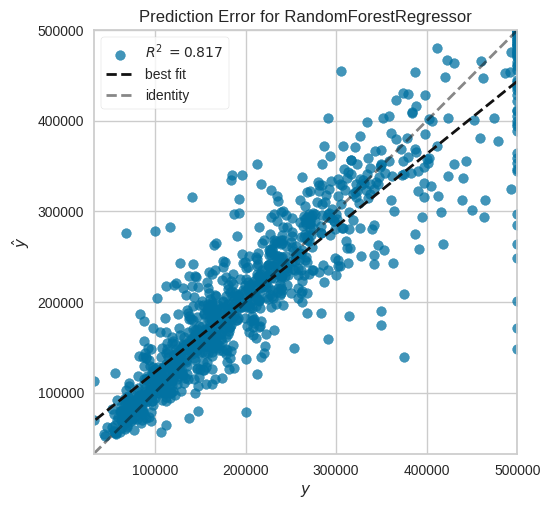

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [165]:
visualizer = PredictionError(model)
visualizer.score(X_cal, y_cal)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [166]:
# calculate calibraion errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [167]:
# calculate quantile with final sample adjustment to ensure coverage
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.951

In [168]:
#calculate q_hat on the calibration set
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)
q_yhat_cal

103260.54722

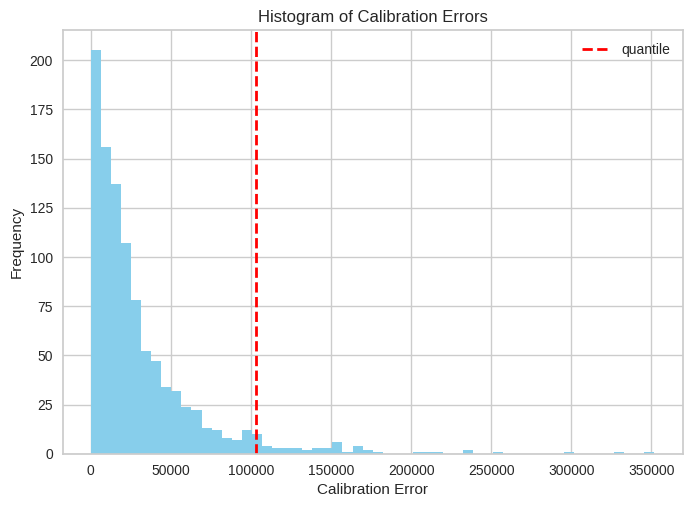

In [169]:
# Plot the histogram
plt.hist(y_cal_error, bins='auto', color='skyblue')

# Add a vertical line for the
plt.axvline(q_yhat_cal, color='red', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')

plt.show()

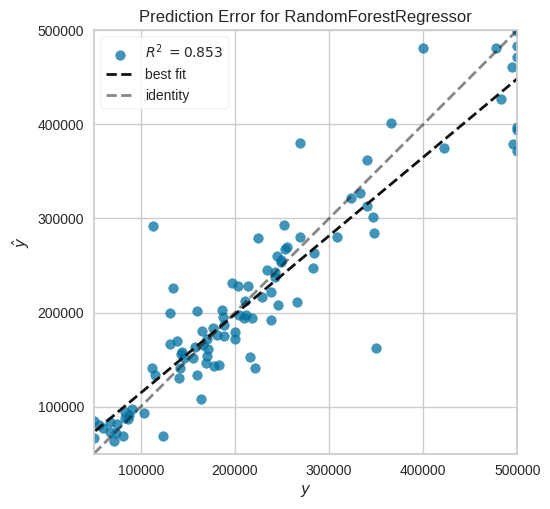

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [170]:
visualizer = PredictionError(model)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [171]:
y_hat_test_lower = y_pred_test - q_yhat_cal
y_hat_test_upper = y_pred_test + q_yhat_cal

In [172]:
predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])
predict_df

,actual,predicted,lower_bound,upper_bound
0,245800.0,208517.00,105256.45278,311777.54722
1,137900.0,169328.00,66067.45278,272588.54722
2,218200.0,194094.00,90833.45278,297354.54722
3,220800.0,141608.00,38347.45278,244868.54722
4,170500.0,171510.00,68249.45278,274770.54722
...,...,...,...,...
95,50000.0,66339.00,-36921.54722,169599.54722
96,500001.0,396988.21,293727.66278,500248.75722
97,55000.0,80693.00,-22567.54722,183953.54722
98,204200.0,197854.00,94593.45278,301114.54722


In [173]:
def calculate_coverage(df):
    df['in_interval'] = df.apply(lambda row: row['lower_bound'] <= row['actual'] <= row['upper_bound'], axis=1)
    coverage = df['in_interval'].mean()
    return coverage

coverage = calculate_coverage(predict_df)
print(f"Coverage: {coverage}")

Coverage: 0.94


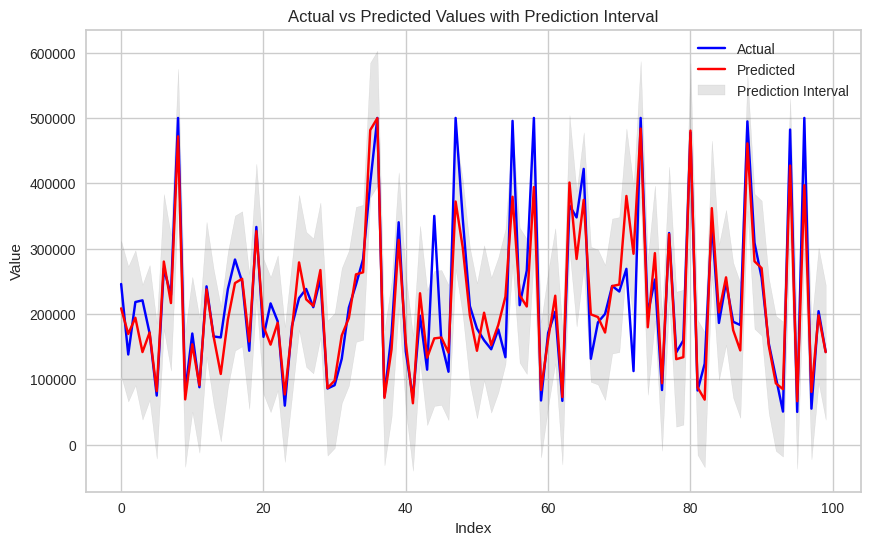

In [174]:
# Sort DataFrame by 'actual' values for smooth line plots
#predict_df = predict_df.sort_values('actual').reset_index(drop=True)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(predict_df['actual'], label='Actual', color='blue')

# Plot predicted values
plt.plot(predict_df['predicted'], label='Predicted', color='red')

# Plot prediction intervals
plt.fill_between(predict_df.index, predict_df['lower_bound'], predict_df['upper_bound'],
                 color='gray', alpha=0.2, label='Prediction Interval')

# Add the legend
plt.legend()

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')

# Show the plot
plt.show()


Distribution of coverage distribution follows the following distribution
\begin{equation}
    \mathbb{E}[1\{y \in C(x_{val})\}| \{(x_i,y_i)\}_{i=1}^{n_{cal}}] \sim  Beta(n_{cal}+1-l,l)
\end{equation}

We can use this result to calculate empirical coverage on the using T trials and verify whether it fits the beta distribution.

\begin{equation}
    C_j=\frac{1}{n_{val}} \sum_{i=1}^{n_{val}} 1\{y_i \in C(x_{val})\},\qquad j \in \{1,2,...,T\}.
\end{equation}

In [175]:
def trial_func():
  # split the datasets into 3 datasets: proper traininig set, calibration and test
  # proper training set is used to train the underlying model, calibration set is used by Conformal Prediction
  # test set is used to test models

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

  # we will use 1000 objects for calibration
  X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

  # we will use Random Forest Regressor to train the underlying model
  model = RandomForestRegressor(n_jobs=-1)
  model.fit(X_proper_train, y_proper_train)

  # make point predictions on the calibration and test sets
  y_pred_cal = model.predict(X_cal)
  y_pred_test = model.predict(X_test)

  # calculate calibraion errors
  y_cal_error = np.abs(y_cal - y_pred_cal)

  # calculate q_hat on the calibration set
  q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)

  # compute upper and lower bounds
  y_hat_test_lower = y_pred_test - q_yhat_cal
  y_hat_test_upper = y_pred_test + q_yhat_cal

  # create dataframe with prediciton results
  predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])

  coverage = calculate_coverage(predict_df)
  return coverage

In [176]:
trial_func()

0.95

In [177]:
# here is how one can compute coverage using regression_coverage_score from MAPIE
regression_coverage_score(predict_df['actual'].values, predict_df['lower_bound'].values, predict_df['upper_bound'].values)

0.94

In [178]:
# # here is how one can compute average prediction interval width using regression_mean_width_score from MAPIE
regression_mean_width_score(predict_df['lower_bound'].values, predict_df['upper_bound'].values)

206521.09444

In [179]:
# we know that ICP is not adaptive and can verify that the average prediction interval width is equal to 2*q_yhat_cal
2*q_yhat_cal

206521.09444

### Conformalized Quantile Regression, Jackknife+ and more (MAPIE)

We will follow MAPIE tutorial for CQR. The target variable of this dataset is the median house value for the California districts. This dataset is composed of 8 features, including ariables such as the age of the house, the median income of the neighborhood, the average numbe rooms or bedrooms or even the location in latitude and longitude. In total there are around 20k observations.

In [180]:
# we compute correlation between features and also between features and the target
# as is clear from the analysis the largest correlation of the house prices is with the median income of the neighbourhood
pear_corr = df.corr(method='pearson')
pear_corr.style.background_gradient(cmap='Greens', axis=0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,class
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,0.688355
class,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,1.000000


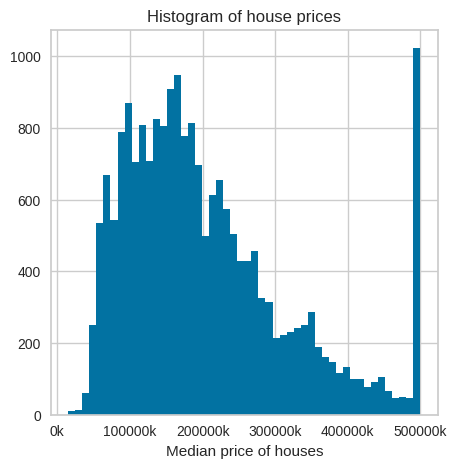

In [181]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(y, bins=50)
axs.set_xlabel("Median price of houses")
axs.set_title("Histogram of house prices")
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
plt.show()

#### Optimize underlying model  

In [182]:
estimator = LGBMRegressor(objective='quantile', alpha=0.5, random_state=random_state)

params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=0
)
optim_model.fit(X_train, y_train)
estimator = optim_model.best_estimator_

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 20333, number of used features: 9
[LightGBM] [Info] Start training from score 179650.000000


In [183]:
estimator

LGBMRegressor(alpha=0.5, learning_rate=0.2550471075104378, max_depth=19,
              n_estimators=295, num_leaves=33, objective='quantile',
              random_state=23)

In [184]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True house prices in $")
    axs.set_ylabel("Prediction of house prices in $")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            + f"Interval width: {np.round(width, round_to)}"
        ),
        xy=(np.min(y_test_sorted_)*3, np.max(y_pred_sorted_+error)*0.95),
        )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

In [185]:
STRATEGIES = {
    "naive": {"method": "naive"},
    "cv_plus": {"method": "plus", "cv": 10},
    "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    "cqr": {"method": "quantile", "cv": "split", "alpha": 0.2},
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)
        mapie.fit(
            X_train, y_train,
            X_calib=X_cal, y_calib=y_cal,
            random_state=random_state
        )
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(estimator, **params, random_state=random_state)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    (
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy]
    ) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )
    width[strategy] = regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 20333, number of used features: 9
[LightGBM] [Info] Start training from score 179650.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 20333, number of used features: 9
[LightGBM] [Info] Start training from score 179650.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 18299, number of used features: 9
[LightGBM] 

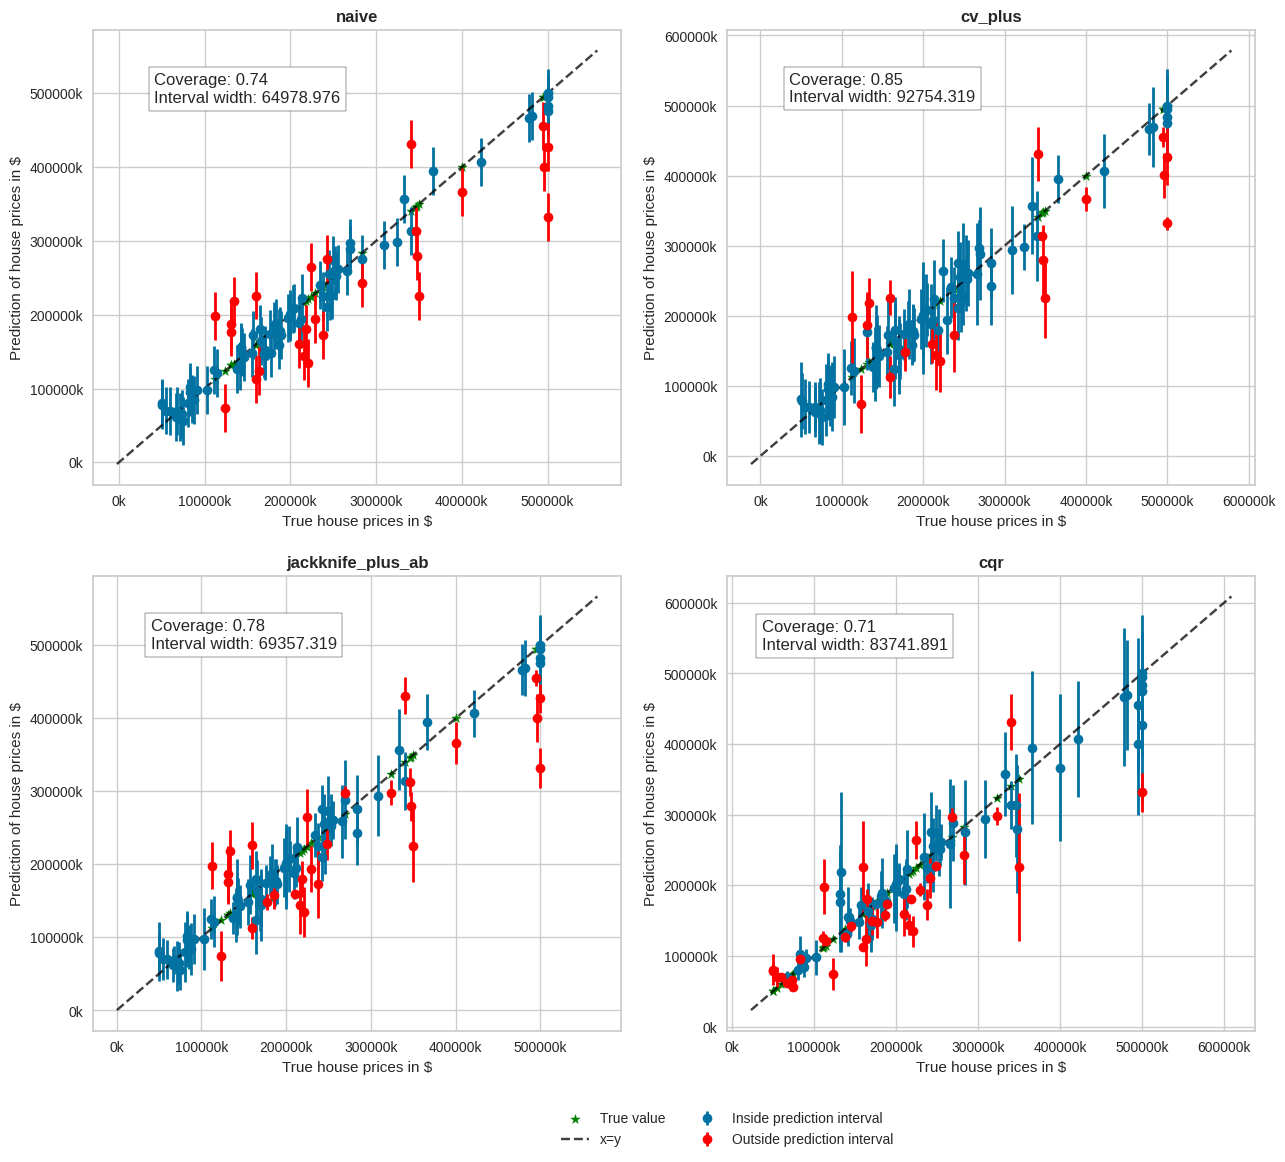

In [186]:
perc_obs_plot = 1
num_plots = rng.choice(
    len(y_test), int(perc_obs_plot*len(y_test)), replace=False
    )
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
for strategy, coord in zip(STRATEGIES.keys(), coords):
    plot_prediction_intervals(
        strategy,
        coord,
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy],
        coverage[strategy],
        width[strategy],
        num_plots
        )
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(0, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2
)
plt.show()

We notice more adaptability of the prediction intervals for the conformalized quantile regression while the other methods have fixed interval width. Indeed, as the prices get larger, the prediction intervals are increased with the increase in price. To confirm these insights, we will now observe what happens when we plot the conditional coverage and interval width on these intervals splitted by quantiles.

In [187]:
def get_coverages_widths_by_bins(
    want,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
):
    """
    Given the results from MAPIE, this function split the data
    according the the test values into bins and calculates coverage
    or width per bin.
    """
    cuts = []
    cuts_ = pd.qcut(y_test["naive"], bins).unique()[:-1]
    for item in cuts_:
        cuts.append(item.left)
    cuts.append(cuts_[-1].right)
    cuts.append(np.max(y_test["naive"])+1)
    recap = {}
    for i in range(len(cuts) - 1):
        cut1, cut2 = cuts[i], cuts[i+1]
        name = f"[{np.round(cut1, 0)}, {np.round(cut2, 0)}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where(
                (y_test[strategy] > cut1) * (y_test[strategy] <= cut2)
                )
            y_test_trunc = np.take(y_test[strategy], indices)
            y_low_ = np.take(lower_bound[strategy], indices)
            y_high_ = np.take(upper_bound[strategy], indices)
            if want == "coverage":
                recap[name].append(regression_coverage_score(
                    y_test_trunc[0],
                    y_low_[0],
                    y_high_[0]
                ))
            elif want == "width":
                recap[name].append(
                    regression_mean_width_score(y_low_[0], y_high_[0])
                )
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df


bins = list(np.arange(0, 1, 0.1))
binned_data = get_coverages_widths_by_bins(
    "coverage",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
)

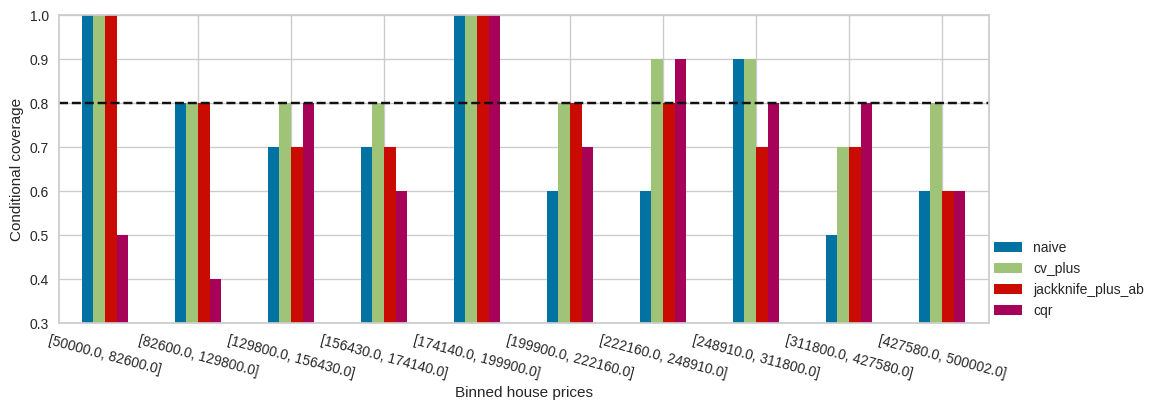

In [188]:
binned_data.T.plot.bar(figsize=(12, 4))
plt.axhline(0.80, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.xlabel("Binned house prices")
plt.xticks(rotation=345)
plt.ylim(0.3, 1.0)
plt.legend(loc=[1, 0])
plt.show()

We can clearly notice that the CQR seems to better adapt to large prices. Its conditional coverage is closer to the target coverage not only for higher prices, but also for lower prices where the other methods have a higher coverage than needed. This will very likely have an impact on the widths of the intervals.

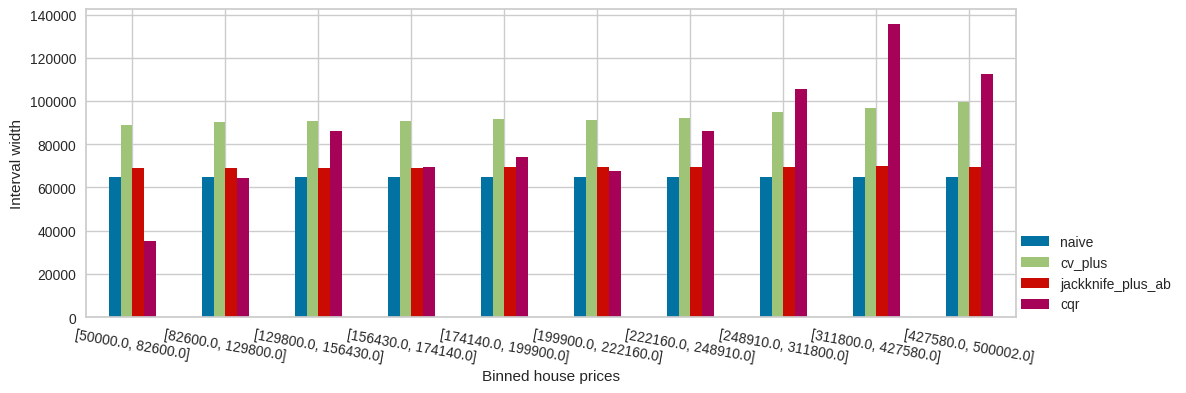

In [189]:
binned_data = get_coverages_widths_by_bins(
    "width",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
)


binned_data.T.plot.bar(figsize=(12, 4))
plt.ylabel("Interval width")
plt.xlabel("Binned house prices")
plt.xticks(rotation=350)
plt.legend(loc=[1, 0])
plt.show()

### Conformal Predictive Distributions (Crepes)

we will follow Crepes quickstart to illustrate how one can use Crepes package
https://github.com/henrikbostrom/crepes

In [190]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

In [191]:
# Let us now "wrap" a RandomForestRegressor from sklearn using the class WrapRegressor from crepes and fit it (in the usual way) to the proper training set:
rf = WrapRegressor(RandomForestRegressor())
rf.fit(X_prop_train, y_prop_train)

In [192]:
# We may now fit a conformal regressor using the calibration set through the calibrate method:
rf.calibrate(X_cal, y_cal)

WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

In [193]:
# The conformal regressor can now produce prediction intervals for the test set, here using a confidence level of 99%:
# The output is a NumPy array with a row for each test instance, and where the two columns specify the lower and upper bound of each prediction interval.
rf.predict_int(X_test, confidence=0.99)

array([[ -85501.3 , 1036612.3 ],
       [-396708.5 ,  725405.1 ],
       [ -59794.49, 1062319.11],
       ...,
       [-376954.82,  745158.78],
       [ -81085.3 , 1041028.3 ],
       [-285572.3 ,  836541.3 ]])

In [194]:
# We may request that the intervals are cut to exclude impossible values, in this case below 0, and if we also rely on the default confidence level (0.95), the output intervals will be a bit tighter:
rf.predict_int(X_test, y_min=0)

array([[233356.91, 717754.09],
       [     0.  , 406546.89],
       [259063.72, 743460.9 ],
       ...,
       [     0.  , 426300.57],
       [237772.91, 722170.09],
       [ 33285.91, 517683.09]])

We will use a DifficultyEstimator from the crepes.extras module for this purpose. Here we estimate the difficulty by the standard deviation of the target of the k (default k=25) nearest neighbors in the proper training set to each object in the calibration set. A small value (beta) is added to the estimates, which may be given through an argument to the function; below we just use the default, i.e., beta=0.01.

In [195]:
# We first obtain the difficulty estimates for the calibration set:
de = DifficultyEstimator()
de.fit(X_prop_train, y=y_prop_train)

sigmas_cal = de.apply(X_cal)

In [196]:
# These can now be used for the calibration, which will produce a normalized conformal regressor:
rf.calibrate(X_cal, y_cal, sigmas=sigmas_cal)

WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

In [197]:
# We need difficulty estimates for the test set too, which we provide as input to predict_int:
sigmas_test = de.apply(X_test)
crepes_predictions = rf.predict_int(X_test, sigmas=sigmas_test, y_min=0)

crepes_predictions

array([[324114.29954226, 626996.70045774],
       [ 66677.02030496, 262019.57969504],
       [393198.71766016, 609325.90233984],
       ...,
       [ 99991.50418975, 268212.45581025],
       [ 76194.93942803, 883748.06057197],
       [184260.2308477 , 366708.7691523 ]])

In [198]:
predict_crepes_df = pd.DataFrame(list(zip(y_test,crepes_predictions[:,0],crepes_predictions[:,1])),
                  columns=['actual','lower_bound','upper_bound'])
predict_crepes_df

,actual,lower_bound,upper_bound
0,435000.0,324114.299542,626996.700458
1,219950.0,66677.020305,262019.579695
2,466500.0,393198.717660,609325.902340
3,520000.0,371693.549479,726650.510521
4,179900.0,131984.870380,260495.489620
...,...,...,...
10802,585000.0,379757.844555,871291.555445
10803,650000.0,395988.914648,891775.165352
10804,110700.0,99991.504190,268212.455810
10805,530000.0,76194.939428,883748.060572


In [199]:
def plot_predictions(df):
  # Calculate coverage
  coverage = calculate_coverage(df)
  print(f"Coverage: {coverage}")

  # Determine the color for each actual value based on whether it falls within the prediction interval
  colors = np.where(
      (df['actual'] >= df['lower_bound']) &
      (df['actual'] <= df['upper_bound']),
      'blue', 'red'
  )

  # Create traces for the plot
  trace_actual = go.Scatter(
      x=df.index,
      y=df['actual'],
      mode='markers',
      marker=dict(color=colors.tolist()),
      name='Actual',
  )

  trace_interval = go.Scatter(
      x=df.index.tolist() + df.index.tolist()[::-1],  # x, then x reversed
      y=df['upper_bound'].tolist() + df['lower_bound'].tolist()[::-1],  # upper, then lower reversed
      fill='toself',
      fillcolor='rgba(255,165,0,0.5)',  # Adjusted alpha to 0.5 for better visibility
      line=dict(color='rgba(255,165,0,1)'),  # Adjusted line color to match fill color
      name='Prediction Interval',
  )

  # Create a layout for the plot
  layout = go.Layout(
      title=f'Actual vs Predicted Values with Prediction Interval<br>Coverage: {coverage:.2%}',
      xaxis_title='Index',
      yaxis_title='Value',
      template='plotly',
      margin=dict(l=60, r=30, b=50, t=50),
  )

  # Create the figure and display the plot
  fig = go.Figure(data=[trace_interval, trace_actual], layout=layout)
  fig.show()


In [200]:
plot_predictions(predict_crepes_df)

Coverage: 0.9495697233274729


Depending on the employed difficulty estimator, the normalized intervals may sometimes be unreasonably large, in the sense that they may be several times larger than any previously observed error. Moreover, if the difficulty estimator is uninformative, e.g., completely random, the varying interval sizes may give a false impression of that we can expect lower prediction errors for instances with tighter intervals. Ideally, a difficulty estimator providing little or no information on the expected error should instead lead to more uniformly distributed interval sizes.

A Mondrian conformal regressor can be used to address these problems, by dividing the object space into non-overlapping so-called Mondrian categories, and forming a (standard) conformal regressor for each category. The category membership of the objects can be provided as an additional argument, named bins, for the fit method.

Here we use the helper function binning from crepes.extras to form Mondrian categories by equal-sized binning of the difficulty estimates; the function returns labels for the calibration objects the we provide as input to the calibration, and we also get thresholds for the bins, which can use later when binning the test objects:

In [201]:
bins_cal, bin_thresholds = binning(sigmas_cal, bins=20)
rf.calibrate(X_cal, y_cal, bins=bins_cal)

WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=True))

In [202]:
bins_test = binning(sigmas_test, bins=bin_thresholds)
crepes_mondrian_predictions = rf.predict_int(X_test, bins=bins_test, y_min=0)
crepes_mondrian_predictions

array([[ 331379.45,  619731.55],
       [  29372.8 ,  299323.8 ],
       [ 366286.81,  636237.81],
       ...,
       [  89883.71,  278320.25],
       [      0.  , 1237670.5 ],
       [ 181266.23,  369702.77]])

In [203]:
predict_crepes_mondrian_df = pd.DataFrame(list(zip(y_test,crepes_mondrian_predictions[:,0],crepes_mondrian_predictions[:,1])),
                  columns=['actual','lower_bound','upper_bound'])
predict_crepes_mondrian_df

,actual,lower_bound,upper_bound
0,435000.0,331379.45,619731.55
1,219950.0,29372.80,299323.80
2,466500.0,366286.81,636237.81
3,520000.0,356714.53,741629.53
4,179900.0,127176.98,265303.38
...,...,...,...
10802,585000.0,395666.20,855383.20
10803,650000.0,414023.54,873740.54
10804,110700.0,89883.71,278320.25
10805,530000.0,0.00,1237670.50


In [204]:
plot_predictions(predict_crepes_mondrian_df)

Coverage: 0.9546590173035995


## Conformal Predictive Distributions (Conformal Predictive Systems)

Conformal Predictive Distributions produce cumulative distribution functions (conformal predictive distributions). From these we can generate prediction intervals, but we can also obtain percentiles, calibrated point predictions, as well as p-values for given target values. Let us see how we can go ahead to do that.

There is only one thing that changes: just provide cps=True to the calibrate method!

We can, for example, form normalized Mondrian conformal predictive systems, by providing both bins and sigmas to the calibrate method. Here we will consider Mondrian categories formed from binning the point predictions:

In [205]:
bins_cal, bin_thresholds = binning(rf.predict(X_cal), bins=5)
rf.calibrate(X_cal, y_cal, sigmas=sigmas_cal, bins=bins_cal, cps=True)

WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True))

By providing the bins (and sigmas) for the test objects, we can now make predictions with the conformal predictive system, through the method predict_cps. The output of this method can be controlled quite flexibly; here we request prediction intervals with 95% confidence to be output:

In [206]:
bins_test = binning(rf.predict(X_test), bins=bin_thresholds)
rf.predict_cps(X_test, sigmas=sigmas_test, bins=bins_test,
               lower_percentiles=2.5, higher_percentiles=97.5, y_min=0)

array([[331284.219423  , 606031.07488181],
       [ 72472.2599139 , 267423.16138841],
       [398314.94294602, 594365.50313183],
       ...,
       [104982.12540885, 272865.79739365],
       [ 95311.57070322, 827848.95148076],
       [189672.94274765, 371755.67539046]])

If we would like to take a look at the p-values for the true targets (these should be uniformly distributed), we can do the following:

In [207]:
rf.predict_cps(X_test, sigmas=sigmas_test, bins=bins_test, y=y_test)


array([0.27182368, 0.92463644, 0.2294169 , ..., 0.03542448, 0.66486247,
       0.52188539])

We may request that the predict_cps method returns the full conformal predictive distribution (CPD) for each test instance, as defined by the threshold values, by setting return_cpds=True. The format of the distributions vary with the type of conformal predictive system; for a standard and normalized CPS, the output is an array with a row for each test instance and a column for each calibration instance (residual), while for a Mondrian CPS, the default output is a vector containing one CPD per test instance, since the number of values may vary between categories.

In [208]:
cpds = rf.predict_cps(X_test, sigmas=sigmas_test, bins=bins_test, return_cpds=True)

The resulting vector of arrays is not displayed here, but we instead provide a plot for the CPD of a random test instance:

In [209]:
len(y_test)

10807

In [210]:
cpds.shape

(10807,)

In [211]:
y_hat_full = rf.predict(X_test)

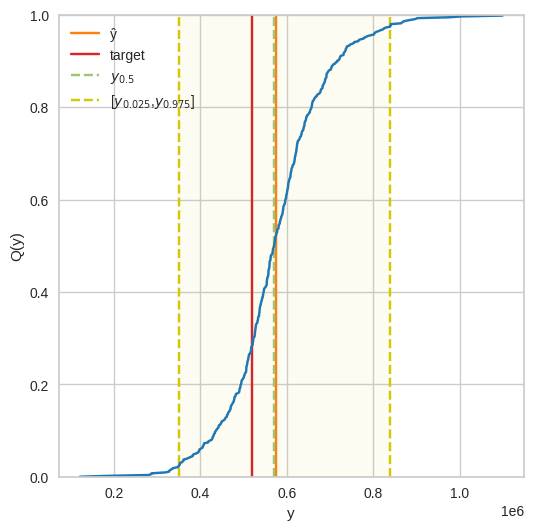

In [212]:
test_index = np.random.randint(len(y_hat_full)) # A test object is randomly selected
cpd = cpds[test_index]

p = np.array([i/len(cpd) for i in range(len(cpd))])

lower_index = np.where(p<=0.025)[0][-1]
mid_index = np.where(p>=0.50)[0][0]
upper_index = np.where(p>=0.975)[0][0]

low_percentile = cpd[lower_index]
median = cpd[mid_index]
high_percentile = cpd[upper_index]

plt.figure(figsize=(6,6))
plt.plot([y_hat_full[test_index],y_hat_full[test_index]],[0,1], color="tab:orange")
plt.plot([y_test[test_index],y_test[test_index]],[0,1], color="tab:red")
plt.xlabel("y")
plt.ylabel("Q(y)")
plt.ylim(0,1)

plt.plot([median,median],[0,1],"g--")
plt.plot([low_percentile,low_percentile],[0,1],"y--")
plt.legend(["ŷ","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
plt.plot([high_percentile,high_percentile],[0,1],"y--")
plt.plot(cpd,p, color="tab:blue")
rectangle = plt.Rectangle((low_percentile,0),
                          abs(high_percentile-low_percentile),1, color="y",
                          alpha=0.05)
plt.gca().add_patch(rectangle)
plt.show()

In [213]:
import plotly.graph_objects as go

# Create traces for the plot
trace1 = go.Scatter(
    x=[y_hat_full[test_index], y_hat_full[test_index]],
    y=[0, 1],
    mode='lines',
    line=dict(color='orange'),
    name='ŷ'
)

trace2 = go.Scatter(
    x=[y_test[test_index], y_test[test_index]],
    y=[0, 1],
    mode='lines',
    line=dict(color='red'),
    name='target'
)

trace3 = go.Scatter(
    x=[median, median],
    y=[0, 1],
    mode='lines',
    line=dict(color='green', dash='dash'),
    name='$y_{0.5}$'
)

trace4 = go.Scatter(
    x=[low_percentile, low_percentile],
    y=[0, 1],
    mode='lines',
    line=dict(color='yellow', dash='dash'),
    name='[$y_{0.025}$,$y_{0.975}$]'
)

trace5 = go.Scatter(
    x=[high_percentile, high_percentile],
    y=[0, 1],
    mode='lines',
    line=dict(color='yellow', dash='dash'),
)

trace6 = go.Scatter(
    x=cpd,
    y=p,
    mode='lines',
    line=dict(color='blue'),
)

# Define rectangle shape
rectangle = dict(
    type="rect",
    x0=low_percentile,
    y0=0,
    x1=high_percentile,
    y1=1,
    fillcolor="yellow",
    opacity=0.05,
    line_width=0,
)

# Create a layout for the plot
layout = go.Layout(
    title='Conformal Predictive Distributions - house_prices',
    xaxis_title='y',
    yaxis_title='Q(y)',
    yaxis_range=[0, 1],
    shapes=[rectangle],
    template='plotly',
    margin=dict(l=60, r=30, b=50, t=50),
)

# Create the figure and display the plot
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6], layout=layout)
fig.show()
